# Creating model for sentiment classification (EN)

## 1. Data retrieval

For this model, movie revies dataset will be used

In [2]:
import nltk
from pathlib import Path
nltk.data.path.append(f"{str(Path.home())}/datasets")
import numpy as np
import pandas as pd
from nltk.corpus import movie_reviews

In [3]:
negids = movie_reviews.fileids('neg')
posids = movie_reviews.fileids('pos')
negfeats = [movie_reviews.words(fileids=[f]) for f in negids]
posfeats = [movie_reviews.words(fileids=[f]) for f in posids]
X = [*negfeats, *posfeats]
X = [" ".join(list(x)) for x in X]
y = [0]*len(negfeats)+[1]*len(posfeats)

In [3]:
sum(y)/len(y) # classes are balanced

0.5

## 2. Classical approach
This will include sklearn toolset to vectorize data and build a classifier

In [6]:
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score

In [5]:
model = make_pipeline(
    TfidfVectorizer(stop_words=nltk.corpus.stopwords.words('english')), 
    GradientBoostingClassifier())


In [6]:
cross_val_score(model, X, y, cv=5)

array([0.7975, 0.7925, 0.805 , 0.7875, 0.8175])

In [1]:
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV

In [7]:
from sklearn.pipeline import Pipeline
from scipy.stats import randint

pipeline_ = Pipeline([
    ("vec", TfidfVectorizer()),
    ("clf", GradientBoostingClassifier())
])

vectorizers = {
    "vec": [CountVectorizer(), TfidfVectorizer()],
    "vec__ngram_range": [(1,1), (1,2), (1,3), (1,4), (1,5)],
    "vec__min_df": randint(1, 10),
    "vec__max_features": [None, 200, 500, 1000, 350, 1500]
}
classifiers = {
    "clf":[GradientBoostingClassifier()],
    "clf__n_estimators":randint(25, 200),
    "clf__max_depth": randint(3, 20),
}


param_distributions = [{
    **vectorizers,
    **classifiers    
}]

In [8]:
%%time
# ~ несколько недель на 6 ядрах Ryzen5
hrscv_ = HalvingRandomSearchCV(
    estimator=pipeline_,
    param_distributions=param_distributions, 
    scoring="f1", 
    n_jobs=6, refit=True, cv=5, verbose=2)
hrscv_.fit(X, y)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 20
Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------
iter: 1
n_candidates: 34
n_resources: 60
Fitting 5 folds for each of 34 candidates, totalling 170 fits
----------
iter: 2
n_candidates: 12
n_resources: 180
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 540
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 56.4 s, sys: 1.08 s, total: 57.5 s
Wall time: 7min 48s


HalvingRandomSearchCV(estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                                ('clf',
                                                 GradientBoostingClassifier())]),
                      n_jobs=6,
                      param_distributions=[{'clf': [GradientBoostingClassifier(max_depth=4,
                                                                               n_estimators=304)],
                                            'clf__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f90d37555b0>,
                                            'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f90d3788400>,
                                            'vec': [CountVectorizer(),
                                                    TfidfVectorizer(min_df=7)],
                                            'vec__max_features': [None, 200,
                                                                

In [9]:
print(hrscv_.best_score_)
print(hrscv_.best_params_)

0.8153942375007965
{'clf': GradientBoostingClassifier(max_depth=4, n_estimators=304), 'clf__max_depth': 4, 'clf__n_estimators': 304, 'vec': TfidfVectorizer(min_df=7), 'vec__max_features': None, 'vec__min_df': 7, 'vec__ngram_range': (1, 1)}


In [10]:
classifier_final = hrscv_.best_estimator_["clf"]
vectorizer_final = hrscv_.best_estimator_["vec"]

## 3. NeuralNetwork approach
Here let's try to build neural network for classification with embeddings layer

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [40]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


LearningRateSchedulerCb = LearningRateScheduler(
    scheduler, 
    verbose=0
)


In [70]:
tokenizer = Tokenizer(
    num_words=5000, 
    lower=True,
    split=' ', 
    char_level=False, 
    oov_token="<OOV>",
)

In [99]:
tokenizer.fit_on_texts(X)

In [100]:
sequences = tokenizer.texts_to_sequences(X)

In [101]:
sequences = pad_sequences(sequences, padding="post", maxlen=1000)

In [102]:
sequences.shape

(2000, 1000)

In [103]:
type(sequences)

numpy.ndarray

In [119]:
tfmodel = Sequential([
    Embedding(5000, 12),
    Bidirectional(LSTM(12, return_sequences=True, dropout=0.2)),
    Bidirectional(LSTM(12, dropout=0.2)),
    Dense(17, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    Dense(1, activation="sigmoid")
])

In [120]:
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [121]:
tfmodel.compile(
    loss="binary_crossentropy", 
    optimizer=adam, 
    metrics=["accuracy"])
tfmodel.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 12)          60000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          2400      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24)                3552      
_________________________________________________________________
dense_19 (Dense)             (None, 17)                425       
_________________________________________________________________
dropout_3 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 18        
Total params: 66,395
Trainable params: 66,395
Non-trainable params: 0
__________________________________________________

In [123]:
history = tfmodel.fit(sequences, np.array(y),
    epochs=40, 
    verbose=1,
#     callbacks=[LearningRateSchedulerCb],
    batch_size=1, 
    validation_split=0.2, 
#     validation_data=(X_test, y_test), 
    shuffle=True, 
#     class_weight=None,
#     sample_weight=None, 
#     initial_epoch=0, 
#     steps_per_epoch=None,
#     validation_steps=None, 
#     validation_batch_size=None, 
#     validation_freq=1,
#     max_queue_size=10, 
#     workers=1, 
#     use_multiprocessing=False
           )

Epoch 1/40
  51/1600 [..............................] - ETA: 11:01 - loss: 0.0022 - accuracy: 1.0000

KeyboardInterrupt: 

Populating the interactive namespace from numpy and matplotlib


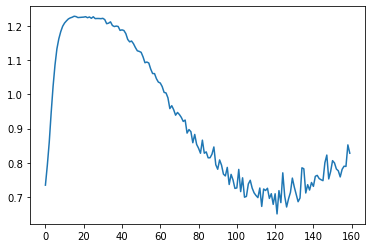

In [108]:
%pylab inline
plot(history.history["val_loss"])

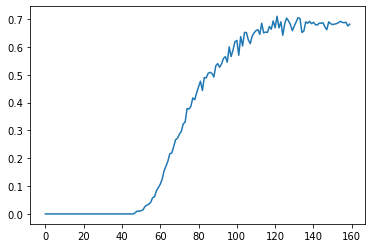

In [109]:
plot(history.history["val_accuracy"])

## 4. Saving model

For sklearn model it is usually OK to use `dill` or `pickle`. 

In [11]:
import dill

In [12]:
classifier_path = "./Classifier.pkl"
vectorizer_path = "./Vectorizer.pkl"

In [13]:
with open(classifier_path, "wb") as fout:
    dill.dump(classifier_final, fout)
with open(vectorizer_path, "wb") as fout:
    dill.dump(vectorizer_final, fout)

For TensorFlow based model I'd better use native TF API

In [110]:
tfmodel.save("TFModel")

INFO:tensorflow:Assets written to: TFModel/assets
